## Import Packages

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

## Define Parameters of Tunnel Diode

In [2]:
q = 1.60218e-19   # Electron charge (C)
k_B = 1.38065e-23 # Boltzmann constant (J/K)
T = 300           # Temperature (K)
a = 0.0039        # Amperes
b = 0.5          # Volts
c = 0.0874        # Volts
d = 0.0073        # Volts
n1 = 0.0352
n2 = 0.0031
h = 0.0367        # Amperes

## Single Hidden Layer Neural Network

In [3]:
class NN(nn.Module):
    def __init__(self, activation_fn):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = activation_fn
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)  # Logits
        return x

In [4]:
class TDAF(nn.Module):
    def __init__(self, clamp=10, vertical_shift=0.3564077949854996, scale=0.44437022056753417):
        super(TDAF, self).__init__()
        self.clamp = clamp
        self.vertical_shift = vertical_shift
        self.scale = scale

    def forward(self, V):
        V = torch.clamp(V, -self.clamp, self.clamp)
        term1 = a * torch.log((1 + torch.exp(q / (k_B * T) * (b - c + n1 * V))) /
                              (1 + torch.exp(q / (k_B * T) * (b - c - n1 * V))))
        term2 = (np.pi / 2) + torch.atan((c - n1 * V) / d)
        term3 = h * (torch.exp(q / (k_B * T) * n2 * V) - 1)
        return (term1 * term2 + term3+self.vertical_shift)/self.scale

## Training and Testing Functions

In [5]:
def test(test_loader, model):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy
    
def train_and_test(model, criterion, lr, num_epochs, train_loader, test_loader, name, val_loader=None):
    # Training the model saving loss and accuracy on all datasets after each epoch
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_values = []
    test_accuracy_values = []
    train_accuracy_values = []
    test_loss_values = []
    val_loss_values = []
    val_accuracy_values = []
    model.eval()
    train_loss=0
    train_batches=0
    test_loss = 0
    test_batches = 0
    val_loss = 0
    val_batches = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0  # Track the cumulative loss for the epoch
        num_batches = 0  # Track the number of batches
    
        for images, labels in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            grads = []
            epoch_loss += loss.item()  # Accumulate loss for each batch
            num_batches += 1

        model.eval()
        test_loss = 0
        test_batches = 0
        val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                test_batches += 1

            avg_test_loss = test_loss / test_batches
            test_loss_values.append(avg_test_loss)
            
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_batches += 1

            avg_val_loss = val_loss / val_batches
            val_loss_values.append(avg_val_loss)
        train_accuracy_values.append(test(train_loader, model))
        test_accuracy_values.append(test(test_loader, model))
        val_accuracy_values.append(test(val_loader, model))
    
        avg_loss = epoch_loss / num_batches
        loss_values.append(avg_loss)

    return loss_values, test_loss_values, val_loss_values, val_accuracy_values, train_accuracy_values, test_accuracy_values


def train(model, criterion, lr, num_epochs, train_loader):
    # Training the model
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_values = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0  # Track the cumulative loss for the epoch
        num_batches = 0  # Track the number of batches
    
        for images, labels in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            grads = []
            epoch_loss += loss.item()  # Accumulate loss for each batch
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        loss_values.append(avg_loss)

    return loss_values

In [6]:
def results(model, num_epochs, loss_values, test_loader, test_dataset):
    # Create figure with subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Define font sizes
    title_size = 16
    label_size = 16
    legend_size = 16
    tick_size = 16
    
    ### Training Loss Plot ###
    axs[0].plot(range(1, num_epochs + 1), loss_values, color='red', linewidth=2)
    axs[0].set_xlabel('Epoch', fontsize=label_size)
    axs[0].set_ylabel('Loss', fontsize=label_size)
    axs[0].set_title('Training Loss', fontsize=title_size)
    axs[0].tick_params(axis='both', labelsize=tick_size)
    axs[0].text(0, 1.03, "(a)", transform=axs[0].transAxes, fontsize=16)
    #axs[0].legend(fontsize=legend_size)
    
    ### Model Evaluation: Predictions ###
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    
    ### Confusion Matrix ###
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    
    # Plot confusion matrix
    disp.plot(ax=axs[1], cmap=plt.cm.Reds, colorbar=False)
    for text in axs[1].texts:
        text.set_fontsize(12)  # Change to your desired font size
    axs[1].set_xlabel('Predicted Label', fontsize=label_size)
    axs[1].set_ylabel('True Label', fontsize=label_size)
    axs[1].tick_params(axis='both', labelsize=tick_size)
    axs[1].set_title('Confusion Matrix', fontsize=title_size)
    axs[1].text(0, 1.03, "(b)", transform=axs[1].transAxes, fontsize=16)

    ### Normalized Accuracy per Class ###
    cm_sum = cm.sum(axis=1, keepdims=True)  # Normalize per class
    cm_normalized = cm / cm_sum
    
    bars = axs[2].bar(range(10), np.diag(cm_normalized), color='tab:red')
    
    # Annotate bars with percentages
    #for bar, acc in zip(bars, np.diag(cm_normalized)):
    #    axs[2].text(bar.get_x() + bar.get_width() / 2, acc + 0.02, f"{acc:.2f}", ha='center', va='bottom', fontsize=10)
    
    axs[2].set_xticks(range(10))
    axs[2].set_xticklabels([str(i) for i in range(10)], fontsize=tick_size)
    axs[2].set_xlabel('Classes', fontsize=label_size)
    axs[2].set_ylabel('Normalised Accuracy', fontsize=label_size)
    #axs[2].set_ylim(0, 1.1)
    axs[2].tick_params(axis='both', labelsize=tick_size)
    axs[2].set_title('Class Accuracy', fontsize=title_size)
    axs[2].grid(axis='y', linestyle='--', alpha=0.6)  # Light grid for readability
    axs[2].text(0, 1.03, "(c)", transform=axs[2].transAxes, fontsize=16)
    
    # Adjust layout
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.3)  # Increase spacing between subplots
    plt.savefig("results_TDAF_a.png", dpi=300)
    ### Sample Test Images with Predictions ###
    fig2, axes = plt.subplots(2, 5, figsize=(15, 7))
    fig2.text(0.01, 0.93, "(d)", fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(test_dataset.data[i], cmap='gray', aspect='auto')
        ax.set_title(f'True: {y_true[i]}\nPred: {y_pred[i]}', fontsize=label_size)
        ax.axis('off')

    #axes[0].text(0, 1.01, "(d)", transform=axes[0].transAxes, fontsize=16)
    fig2.tight_layout()

    # Save figures if needed
    
    plt.savefig("results_TDAF_b.png", dpi=300)
    
    plt.show()

## Test Initialisation

In [7]:
init_tdaf = []
init_relu = []
init_sigmoid = []
batch = 256
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch, shuffle=False)
for i in range(10):
    init_tdaf.append(test(test_loader, NN(TDAF())))
    init_relu.append(test(test_loader, NN(nn.ReLU())))
    init_sigmoid.append(test(test_loader, NN(nn.Sigmoid())))

print(f"TDAF: {sum(init_tdaf)/len(init_tdaf)}")
print(f"ReLU: {sum(init_relu)/len(init_relu)}")
print(f"Sigmoid: {sum(init_sigmoid)/len(init_sigmoid)}")

TDAF: 0.09825
ReLU: 0.08222
Sigmoid: 0.09094


## Training Model

### Train TDAF NN Once and Generate Confusion Matrix and Class Accuracies

Training TDAF model...


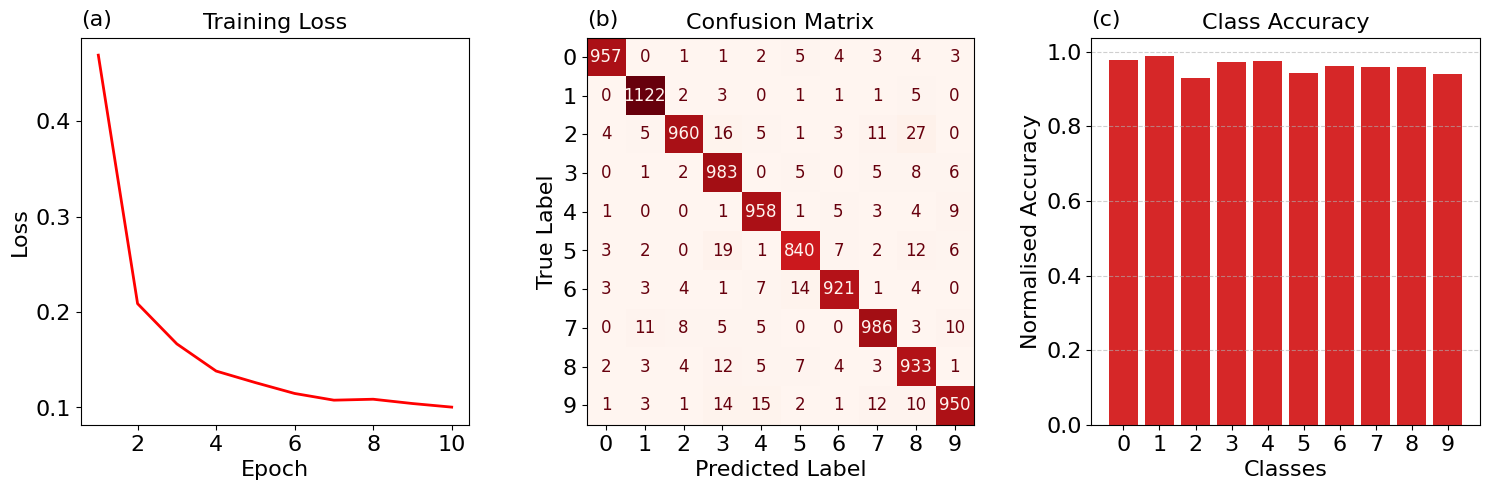

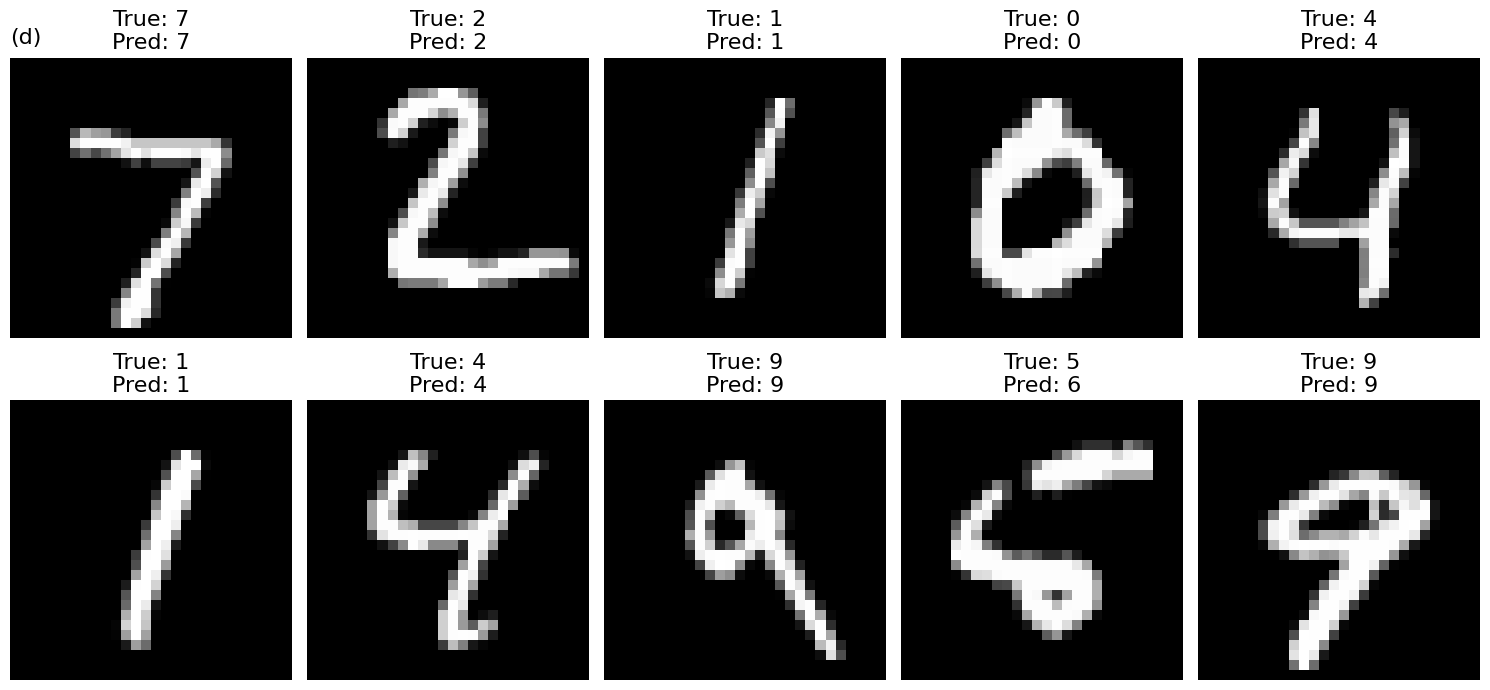

In [8]:
# Hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()

# Data Transformations (only define once)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST Dataset Once
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


# Models to train
models = {
    "TDAF": TDAF(),
}
lr = 0.01
batch = 256
# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch, shuffle=False)

for model_name, activation in models.items():
    print(f"Training {model_name} model...")
    # Initialize model
    model = NN(activation)
    # Train & Test the model. Not using val set so passing in test as val
    train_loss, test_loss, val_loss, val_acc, train_acc, test_acc = train_and_test(model, criterion, lr, epochs, train_loader, test_loader, model_name, test_loader)
    results(model, epochs, train_loss, test_loader, test_dataset)

### Train TDAF, ReLU, and Sigmoid NNs Multiple Times

In [9]:
# Hyperparameters
epochs = 2
criterion = nn.CrossEntropyLoss()
results = dict()

# Data Transformations (only define once)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST Dataset Once
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


# Models to train
models = {
    "TDAF": TDAF(),
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid()
}
iterations = 2
for lr in [0.01]:
    for batch in [256]:
        # Training Loop
        for i in range(iterations):
            print(f"Iteration {i+1}/{iterations}")
            # Split dataset once
            train_subset, val_subset = random_split(train_dataset, [int(0.8 * len(train_dataset)), int(0.2 * len(train_dataset))])
            
            # Create DataLoaders
            train_loader = DataLoader(dataset=train_subset, batch_size=batch, shuffle=True)
            val_loader = DataLoader(dataset=val_subset, batch_size=batch, shuffle=True)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch, shuffle=False)
        
            for model_name, activation in models.items():
                print(f"Training {model_name} model...")
        
                # Initialize model
                model = NN(activation)
        
                # Train & Test the model
                train_loss, test_loss, val_loss, val_acc, train_acc, test_acc = train_and_test(
                    model, criterion, lr, epochs, train_loader, test_loader, model_name, val_loader
                )
        
                # Expand accuracy & loss lists into separate columns
                results[f"{model_name}_{batch}_{lr}_train_accuracy_{i}"] = train_acc
                results[f"{model_name}_{batch}_{lr}_test_accuracy_{i}"] = test_acc
                results[f"{model_name}_{batch}_{lr}_val_accuracy_{i}"] = val_acc
                results[f"{model_name}_{batch}_{lr}_train_loss_{i}"] = train_loss
                results[f"{model_name}_{batch}_{lr}_test_loss_{i}"] = test_loss
                results[f"{model_name}_{batch}_{lr}_val_loss_{i}"] = val_loss
        
        
                # Print test results for debugging
                print(f"{model_name}: {test(test_loader, model)}")

# **Convert the list of dictionaries into a DataFrame in one operation**
df = pd.DataFrame(results)

Iteration 1/2
Training TDAF model...
TDAF: 0.9443
Training ReLU model...
ReLU: 0.9396
Training Sigmoid model...
Sigmoid: 0.9315
Iteration 2/2
Training TDAF model...
TDAF: 0.9399
Training ReLU model...
ReLU: 0.927
Training Sigmoid model...
Sigmoid: 0.9206


In [ ]:
# Hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
results = dict()

# Data Transformations (only define once)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST Dataset Once
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


# Models to train
models = {
    "TDAF": TDAF(),
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid()
}

for lr in np.logspace(-4, -2, 27):
    for batch in [256]:
        print(lr)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch, shuffle=False)
        for model_name, activation in models.items():
            result = 0
            for i in range(5):
                print(f"Training {model_name} model...")
                # Initialize model
                model = NN(activation)
                # Train & Test the model
                train_loss = train(model, criterion, lr, epochs, train_loader)
                # Print test results for debugging
                result += test(test_loader, model)
            results[f"{model_name}_{batch}_{lr}"]=result/5

In [ ]:
TDAFs=[]
ReLUs=[]
Sigmoids=[]
for batch in np.logspace(-4, -2, 27):
    TDAFs.append(results[f"TDAF5_256_{batch}"])
    Sigmoids.append(results[f"Sigmoid_256_{batch}"])
    ReLUs.append(results[f"ReLU_256_{batch}"])
df5 = pd.DataFrame({"LR":np.logspace(-4, -2, 27), "TDAF":TDAFs, "ReLU":ReLUs, "Sigmoid":Sigmoids})

### Visualising Results

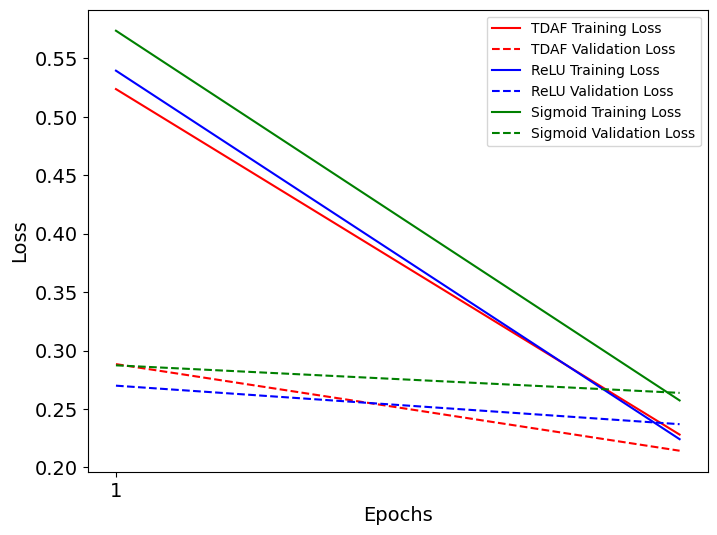

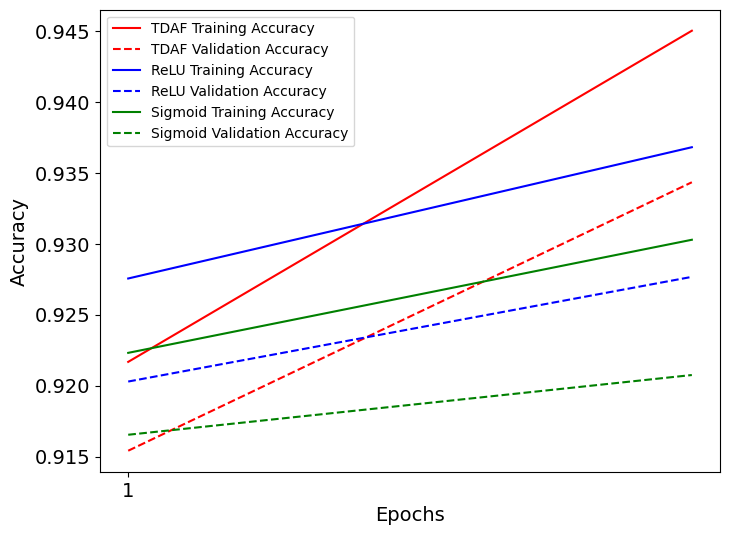

In [10]:
# Group columns by base name (removing numeric suffixes)
column_groups = {}
for col in df.columns:
    if "val" in col or "train" in col:
        base_name = "_".join(col.split("_")[:-1])  # Remove last part (numeric suffix)
        column_groups.setdefault(base_name, []).append(col)

# Compute the average for each group
df_avg = pd.DataFrame()
for base_name, columns in column_groups.items():
    df_avg[base_name] = df[columns].mean(axis=1)
    
# Plot with different styles based on whether "val" is in the name
plt.figure(figsize=(8, 6))
for col in df_avg.columns:
    if "loss" in col and "test" not in col:
        linestyle = "dashed" if "val" in col else "solid"
        color = "r" if "TDAF" in col else "g" if "Sigmoid" in col else "b"
        plt.plot(df_avg.index+1, df_avg[col], label=col, color = color,linestyle=linestyle)

# Add labels, title, and legend
plt.xlabel("Epochs", fontsize=14)
plt.gca().set_xticks(np.arange(1, epochs, 1))
plt.legend(["TDAF Training Loss", "TDAF Validation Loss", "ReLU Training Loss", "ReLU Validation Loss", "Sigmoid Training Loss", "Sigmoid Validation Loss"])
plt.grid(False)
plt.ylabel("Loss", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
# Plot with different styles based on whether "val" is in the name
plt.figure(figsize=(8, 6))
for col in df_avg.columns:
    if "accuracy" in col and "test" not in col:
        linestyle = "dashed" if "val" in col else "solid"
        color = "r" if "TDAF" in col else "g" if "Sigmoid" in col else "b"
        plt.plot(df_avg.index+1, df_avg[col], label=col, color = color,linestyle=linestyle)

# Add labels, title, and legend
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.gca().set_xticks(np.arange(1, epochs, 1))
plt.legend(["TDAF Training Accuracy", "TDAF Validation Accuracy", "ReLU Training Accuracy", "ReLU Validation Accuracy", "Sigmoid Training Accuracy", "Sigmoid Validation Accuracy"])
plt.grid(False)

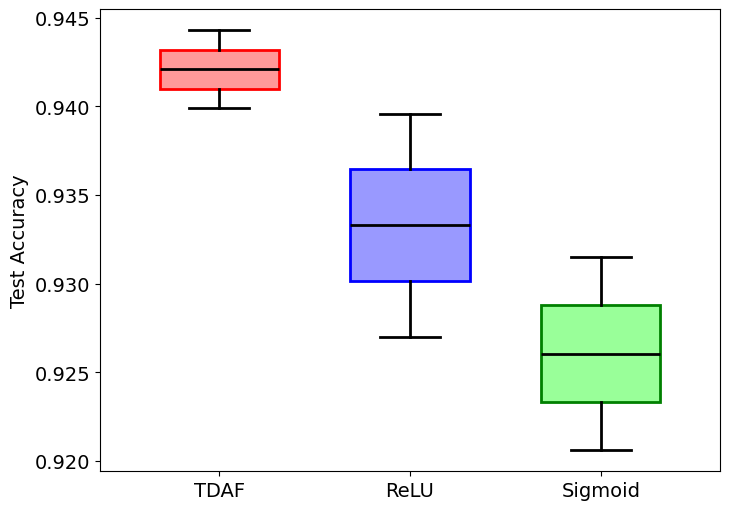

In [11]:
# Extract the final row
cols = []
for col in df.columns:
    if "test_accuracy" in col:
        cols.append(col)

test_df = df[cols]
final_row = test_df.iloc[-1:].copy()

# Separate columns for each activation function
tdaf_cols = [col for col in final_row.columns if "TDAF" in col]
relu_cols = [col for col in final_row.columns if "ReLU" in col]
sigmoid_cols = [col for col in final_row.columns if "Sigmoid" in col]

# Create a new DataFrame with the required format
df_restructured = pd.DataFrame({
    "TDAF": final_row[tdaf_cols].values.flatten(),
    "ReLU": final_row[relu_cols].values.flatten(),
    "Sigmoid": final_row[sigmoid_cols].values.flatten()
})
# Define custom colors for each activation function
fill_colors = [(1, 0, 0, 0.4),
               (0, 0, 1, 0.4),  
               (0, 1, 0, 0.4)]

edge_colors = ["red", "blue", "green"]  # Solid edge colors

# Create figure
plt.figure(figsize=(8, 6))

# Create the boxplot without outliers
box = plt.boxplot([df_restructured["TDAF"], df_restructured["ReLU"], df_restructured["Sigmoid"]],
                   tick_labels=["TDAF", "ReLU", "Sigmoid"],
                   patch_artist=True,  # Allows setting facecolors
                   showfliers=False,
                   positions=[0, 0.8, 1.6],
                   widths=0.5)  # Hide outliers)

# Apply different colors to each box
for patch, edge_color, fill_color in zip(box['boxes'], edge_colors, fill_colors):
    patch.set_facecolor(fill_color)  # Set semi-transparent fill
    patch.set_edgecolor(edge_color)  # Set solid edge color
    patch.set_linewidth(2)  # Make edge bold

for median in box['whiskers']:
    median.set(color="black", linewidth=2)

for median in box['caps']:
    median.set(color="black", linewidth=2)
# Customize median lines
for median in box['medians']:
    median.set(color="black", linewidth=2)

# Add labels and title
plt.ylabel("Test Accuracy", fontsize=14)
plt.tick_params(axis='both', labelsize=14)

In [ ]:
# Hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
results = dict()
lrs = [0.01, 0.005, 0.001]
batches = [64, 128, 256]

# Data Transformations (only define once)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST Dataset Once
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

iterations = 1

# Models to train
models = {
    "TDAF": TDAF(),
    "ReLU": nn.ReLU(),
    "Sigmoid": nn.Sigmoid()
}

for lr in lrs:
    for batch in batches:
        print(f"Learning Rate = {lr}, Batch = {batch}")
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch, shuffle=False)
        for model_name, activation in models.items():
            result = 0
            for i in range(iterations):
                print(f"Training {model_name} model...")
                # Initialize model
                model = NN(activation)
                # Train & Test the model
                train_loss = train(model, criterion, lr, epochs, train_loader)
                result += test(test_loader, model)
            results[f"{model_name}_{batch}_{lr}"]=result/iterations